In [1]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval
!pip install diffusers

Cloning into 'diffusion'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 322 (delta 180), reused 228 (delta 90), pack-reused 0 (from 0)
Receiving objects: 100% (322/322), 9.76 MiB | 24.20 MiB/s, done.
Resolving deltas: 100% (180/180), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.6 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.0 MB/s eta 0:00:0000:01:00:01


In [2]:
from diffusers import UNet2DModel

import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt, sys
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))

from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)


In [4]:
xl,yl = 'img','label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
dt = dls.train
xb,yb = next(iter(dt))

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [6]:
xb[0].shape

torch.Size([3, 32, 32])

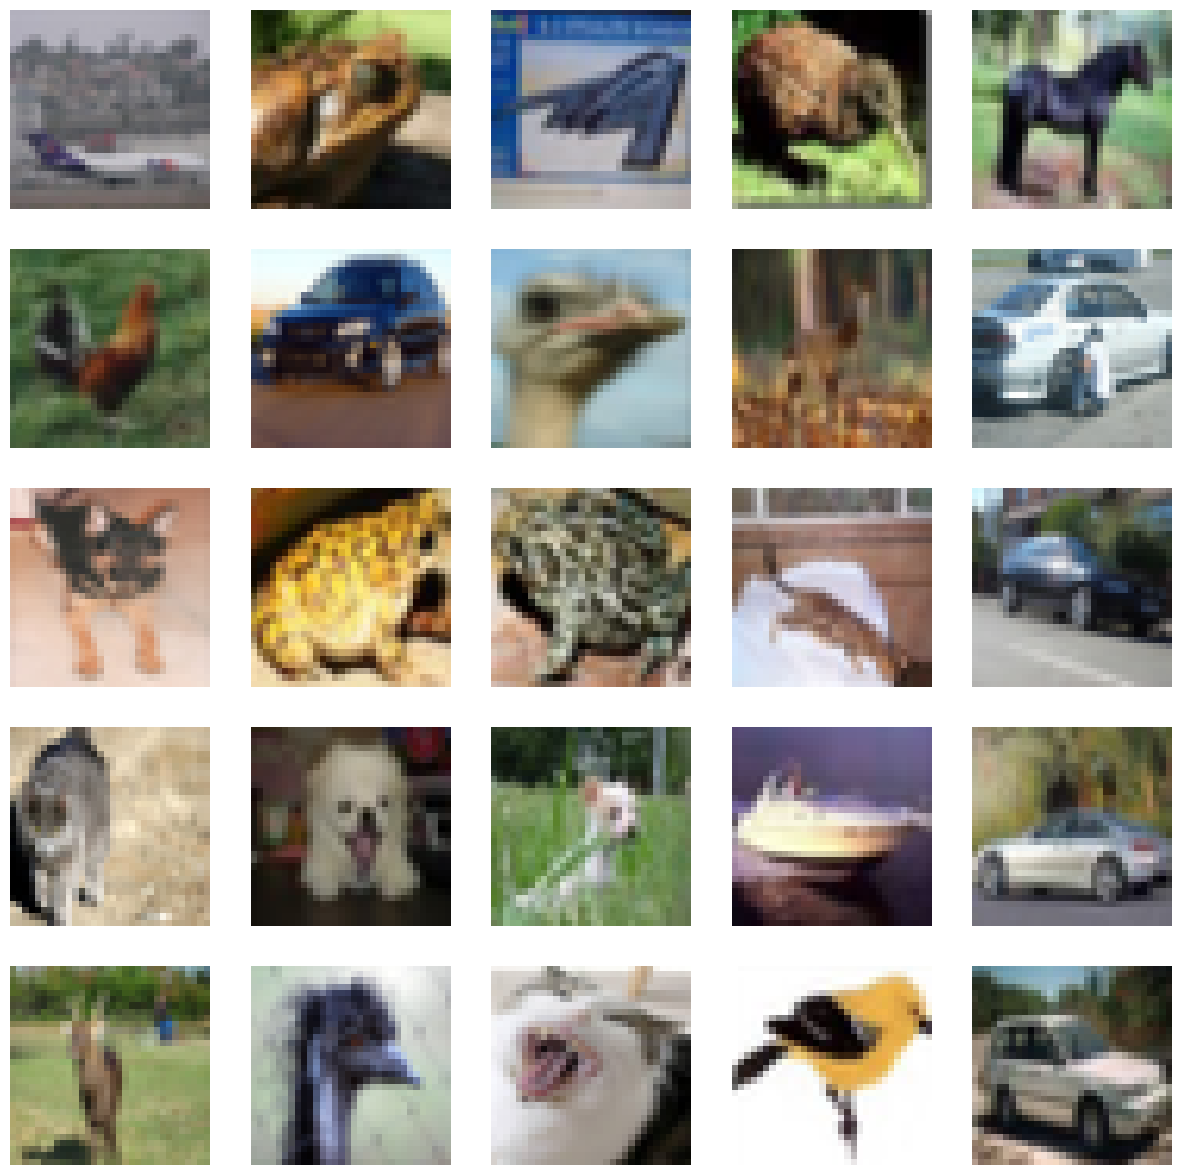

In [7]:
show_images(xb[:25]+0.5)

In [8]:
xb.shape

torch.Size([32, 3, 32, 32])

In [6]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [7]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [8]:
(xt, t), epsilon = noisify(xb[:25], alphabar)
t

tensor([246, 362, 207, 896, 406, 401, 768, 629, 433, 927, 202, 176, 783, 383,
        394, 396, 836, 344, 382, 779, 518, 924, 394, 503, 447])

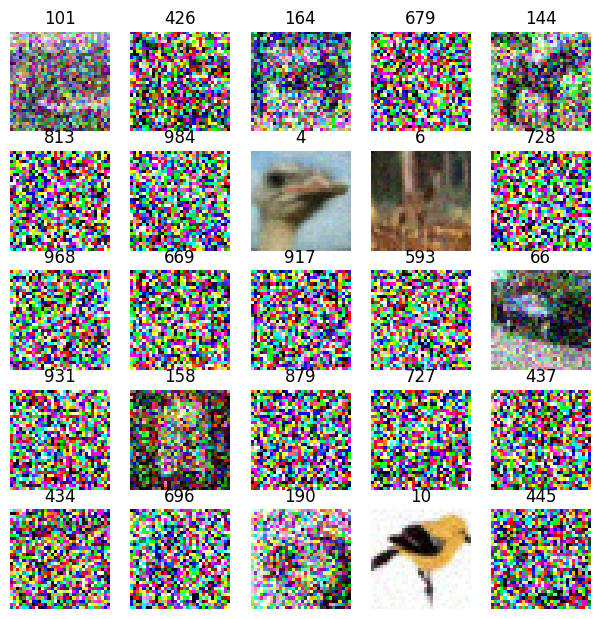

In [13]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)

# Training

In [9]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
# def noisify(x_0, alpha_bar):
#     device = x_0.device
#     n = len(x_0)
#     t = torch.randint(0, n_steps, (n,), dtype=torch.long)
#     epsilon = torch.randn(x_0.shape, device=device)
#     alpha_bar_t = alpha_bar[t].reshape(-1, 1, 1, 1).to(device)
#     xt = alpha_bar_t.sqrt()*x_0 + (1-alpha_bar_t).sqrt()*epsilon
#     return (xt, t.to(device)), epsilon

In [ ]:
# def collate_ddpm(b,alphabar, xl): return noisify(default_collate(b)[xl], alphabar)
# def dl_ddpm(ds, bs, collate_fn, nw): return DataLoader(ds, batch_size=bs, collate_fn=collate_fn, num_workers=nw)

In [10]:
collatefn = partial(collate_ddpm, alphabar=alphabar, xl=xl)
dls = DataLoaders(dl_ddpm(tds['train'], bs=bs, nw=4, collate_fn=collatefn),
                  dl_ddpm(tds['test'],  bs=bs, nw=4, collate_fn=collatefn))

In [16]:
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
sum(p.numel() for p in model.parameters())

15891907

In [12]:
clean_mem()

In [26]:
len(dls.train)

1563

In [27]:
lr = 1e-3
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * 2 * len(dls.train) + 1
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecisionCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MultiGPUsCallback()]
model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

Using 2 GPUs for training


/kaggle/working/diffusion/callbacks/mixed_precision_callback.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


loss,epoch,train
0.055,0,True
0.028,0,False


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


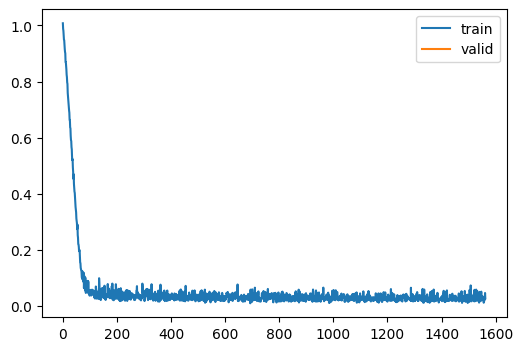

In [28]:
learn.fit(epochs)

In [29]:
%%time
samples = sample(model, (bs, 3, 32, 32), alpha, alphabar, sigma, n_steps)

CPU times: user 5min 41s, sys: 203 ms, total: 5min 41s
Wall time: 5min 41s


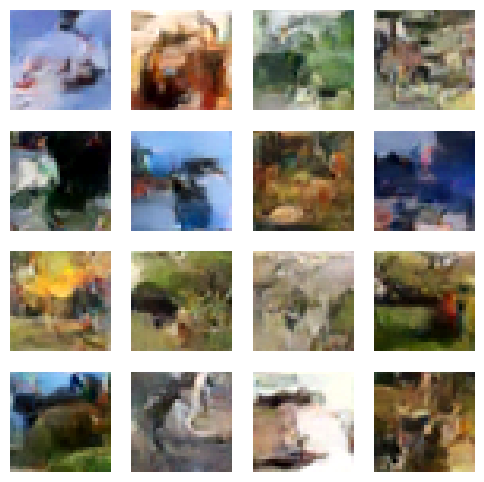

In [30]:
s = (samples[-1] + 0.5).clamp(0, 1)
show_images(s[:16], imsize=1.5)

# W&B callback

In [11]:
import wandb

class WandbCB(MetricsCB):
    order = 100
    def __init__(self, config, *ms, project="ddpm_cifar10", **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)
    def before_batch(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()
    
    def _log(self, d):
        if self.train:
            wandb.log({'train_' + m:float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+m : float(d[m]) for m in self.all_metrics})
            wandb.log({'samples': self.sample_figure(learn)})
        print(d)
        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16,3,32,32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im, ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig
    def after_batch(self, learn):
        super().after_batch(learn)
        wandb.log({"loss": learn.loss})

In [12]:
lr = 1e-3
epochs = 10
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train) * 2 + 1
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
# wandbcb = WandbCB(config={"lr":lr, 'epochs':epochs, "comment":'default unet loggint test'})
cbs = [DeviceCB(),
       MixedPrecisionCB(),
       ProgressCB(plot=True),
#        wandbcb,
       BatchSchedCB(sched),
       MultiGPUsCallback()]
model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [13]:
learn.fit(epochs)

Using 2 GPUs for training


/kaggle/working/diffusion/callbacks/mixed_precision_callback.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


In [14]:
%%time
samples = sample(model, (bs, 3, 32, 32), alpha, alphabar, sigma, n_steps)

0it [00:00, ?it/s]

CPU times: user 5min 29s, sys: 533 ms, total: 5min 30s
Wall time: 5min 29s


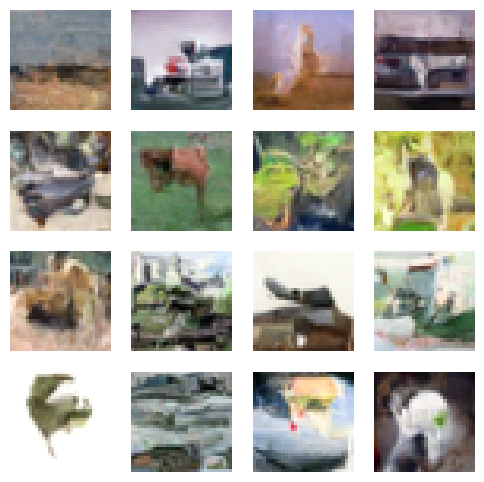

In [15]:
s = (samples[-1] + 0.5).clamp(0, 1)
show_images(s[:16], imsize=1.5)

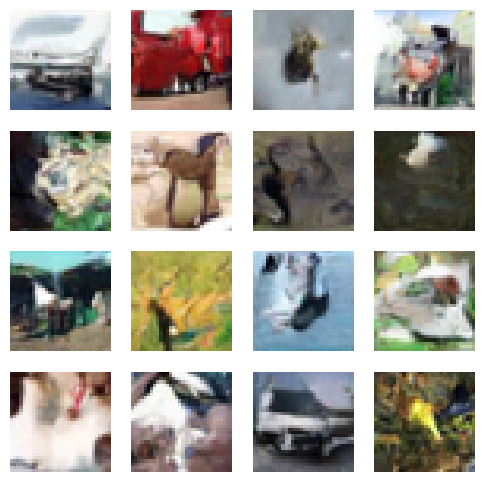

In [16]:
s = (samples[-1] + 0.5).clamp(0, 1)
show_images(s[16:], imsize=1.5)